## 3.6 Robustness to Environment Changes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

# Environment config
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],
    [0.2, 0.6, 0.3, 0.15],
    [0.1, 0.4, 0.5, 0.3],
    [0.25, 0.35, 0.3, 0.2],
    [0.15, 0.5, 0.25, 0.4]
]
env = DynamicPricingEnv(prices, change_points, reward_probabilities)

In [2]:
class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.time = 0

    def select_arm(self):
        self.time += 1
        ucb_values = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.counts[i] == 0:
                return i
            bonus = np.sqrt((2 * np.log(self.time)) / self.counts[i])
            ucb_values[i] = self.values[i] + bonus
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts = self.gamma * self.counts
        self.counts[arm] += 1
        self.values[arm] = self.values[arm] + (reward - self.values[arm]) / self.counts[arm]

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]
        self.time = 0

    def select_arm(self):
        for arm in range(self.n_arms):
            if len(self.rewards[arm]) == 0:
                return arm
        total_pulls = sum(len(rewards) for rewards in self.rewards)
        ucb_values = []
        for arm in range(self.n_arms):
            cnt = len(self.rewards[arm])
            avg = sum(self.rewards[arm]) / cnt
            ucb = avg + np.sqrt((2 * np.log(total_pulls)) / cnt)
            ucb_values.append(ucb)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

class EpsilonGreedy:
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(0, self.num_arms)
        else:
            return np.argmax(self.values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class UCB:
    def __init__(self, n_arms, c=2):
        self.n_arms = n_arms
        self.c = c
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.t = 1

    def select_arm(self):
        if 0 in self.counts:
            return np.argmin(self.counts)
        
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class ThompsonSampling:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)
        self.failures = np.zeros(n_arms)

    def select_arm(self):
        samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.n_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1


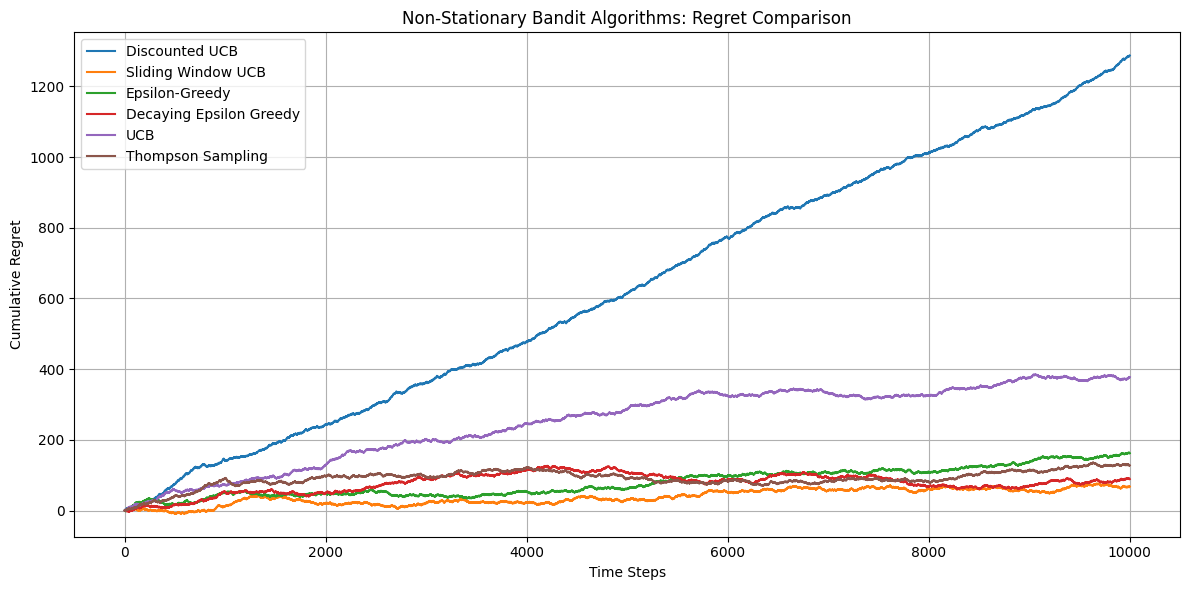

In [4]:
# Run simulation
env.reset()
T = 10000

def epsilon_schedule(t):
    return 1 / (t + 1)

agents = {
    'Discounted UCB': DiscountedUCB(len(prices)),
    'Sliding Window UCB': SlidingWindowUCB(len(prices)),
    'Epsilon-Greedy': EpsilonGreedy(len(prices)),
    'Decaying Epsilon Greedy': EpsilonGreedyDecaying(len(prices), epsilon_schedule),
    'UCB': UCB(len(prices)),
    'Thompson Sampling': ThompsonSampling(len(prices))
}
regret_log = {name: [] for name in agents}

for t in range(T):
    for name, agent in agents.items():
        arm = agent.select_arm()
        reward = env.step(arm)
        agent.update(arm, reward)
        regret_log[name].append(max(reward_probabilities[env.current_phase]) - reward)

# Plot
plt.figure(figsize=(12, 6))
for name, regrets in regret_log.items():
    plt.plot(np.cumsum(regrets), label=name)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("Non-Stationary Bandit Algorithms: Regret Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.5 Sensitivity to the MAB Problem

In [7]:
# Define bandit environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])


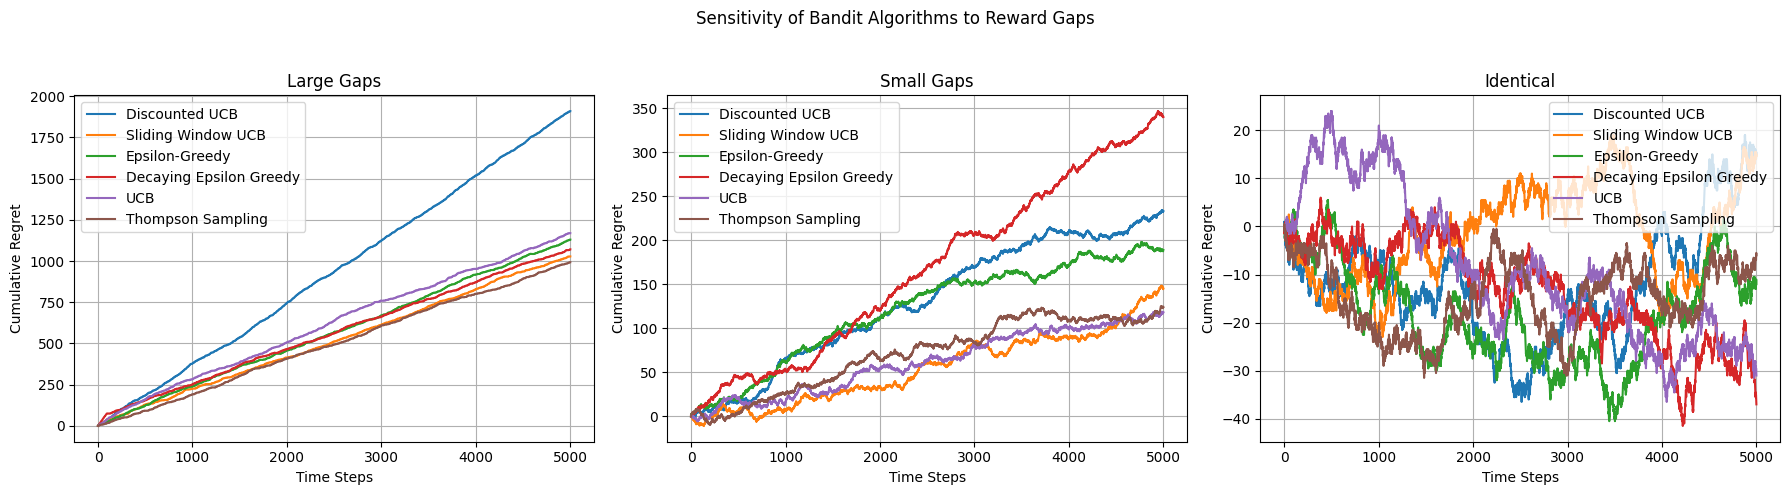

In [ ]:
# Run experiment
def run_experiment(agent_class, agent_args, reward_means, T):
    env = BanditEnvironment(len(reward_means), reward_means)
    agent = agent_class(**agent_args)
    regrets = []
    optimal_reward = max(reward_means)

    for _ in range(T):
        arm = agent.select_arm()
        reward = env.pull_arm(arm)
        agent.update(arm, reward)
        regrets.append(optimal_reward - reward)

    return np.cumsum(regrets)

# Settings
reward_sets = {
    "Large Gaps": [0.1, 0.3, 0.5, 0.7, 0.9],
    "Small Gaps": [0.48, 0.5, 0.52, 0.53, 0.54],
    "Identical": [0.5, 0.5, 0.5, 0.5, 0.5]
}
T = 5000

def epsilon_schedule(t):
    return 1 / (t + 1)

algorithms = {
    'Discounted UCB': (DiscountedUCB, {'n_arms': len(prices), 'gamma': 0.99}),
    'Sliding Window UCB': (SlidingWindowUCB, {'n_arms': len(prices), 'window_size': 50}),
    'Epsilon-Greedy': (EpsilonGreedy, {'n_arms': len(prices), 'epsilon': 0.1}),
    'Decaying Epsilon Greedy': (EpsilonGreedyDecaying, {'num_arms': len(prices), 'epsilon_schedule': epsilon_schedule}),
    'UCB': (UCB, {'n_arms': len(prices), 'c': 2}),
    'Thompson Sampling': (ThompsonSampling, {'n_arms': len(prices)})
}
# Run and plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for idx, (label, rewards) in enumerate(reward_sets.items()):
    for algo_name, (algo_class, algo_args) in algorithms.items():
        regret = run_experiment(algo_class, algo_args, rewards, T)
        axs[idx].plot(regret, label=algo_name)
    axs[idx].set_title(label)
    axs[idx].set_xlabel("Time Steps")
    axs[idx].set_ylabel("Cumulative Regret")
    axs[idx].legend()
    axs[idx].grid(True)

plt.suptitle("Sensitivity of Bandit Algorithms to Reward Gaps")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()